In [60]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function

In [61]:
WEIGHTS=[]
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=21

# namespace items_merged from load_data file
items_merged = load_data.items_merged

In [62]:
genetic_error=[]
flower_error=[]
fuzzy_error=[]

In [63]:
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

In [64]:
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


In [65]:
def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))



In [66]:
def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


#fuzzy


In [67]:
def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.array(fuzzy_vec[j][:-1])) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:50]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
   # WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    fuzzy_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    #print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(fuzzy_error)/len(fuzzy_error))
#average of erro overt the time 
plt.plot(fuzzy_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  0
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  1
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  2
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  3
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  4
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  5
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  6
Error:  1.1197781116536607


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/864181355.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


KeyboardInterrupt: 

// Genetic operator


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  0
Error:  1.1197781116536607
Weights after iteration is:  [0.70097511 0.6121378  0.41273786 0.81255731 0.04248189 0.57453766
 0.95940093 0.50932064 0.86921908 0.84828474 0.10627918 0.28854508
 0.02126162 0.38183541 0.93861741 0.6213937  0.42509484 0.43375901
 0.82465363 0.36275132 0.02586306]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  1
Error:  1.1197781116536607
Weights after iteration is:  [0.87232255 0.31382329 0.25061294 0.88100093 0.84368145 0.96638032
 0.48705737 0.46883519 0.06200505 0.05744949 0.72610554 0.34998745
 0.49116036 0.61062144 0.93441342 0.01792176 0.83566381 0.32404959
 0.23865282 0.06196998 0.90728611]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  2
Error:  1.1197781116536607
Weights after iteration is:  [0.36064875 0.53984097 0.4713155  0.83862444 0.48374156 0.85781362
 0.5537805  0.31392022 0.130115   0.22063643 0.61714335 0.09785989
 0.79951167 0.40644263 0.14826384 0.45950856 0.58773255 0.56071516
 0.15609556 0.03773518 0.99504657]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  3
Error:  1.1197781116536607
Weights after iteration is:  [0.17062342 0.89025613 0.54216636 0.18018606 0.28241346 0.42833995
 0.75290804 0.17720684 0.90934407 0.62686949 0.31709037 0.46269987
 0.27211083 0.03439486 0.0453945  0.95880528 0.56056134 0.299207
 0.45423552 0.32977621 0.62387856]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  4
Error:  1.1197781116536607
Weights after iteration is:  [0.10205618 0.72159816 0.21145221 0.90943806 0.74209839 0.09512862
 0.23895759 0.10887265 0.16365002 0.14733511 0.04735523 0.02793312
 0.35494602 0.6501569  0.26539976 0.62789218 0.96958781 0.66370367
 0.48904986 0.50249372 0.48385536]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  5
Error:  1.1197781116536607
Weights after iteration is:  [0.69178072 0.85181779 0.15526342 0.08742907 0.29843145 0.14286008
 0.61987135 0.09366905 0.15565771 0.19145189 0.81670016 0.63979919
 0.36303144 0.66745439 0.6707833  0.56211641 0.93709138 0.66570388
 0.07285793 0.53605064 0.09170349]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  6
Error:  1.1197781116536607
Weights after iteration is:  [0.76045954 0.89545998 0.07767415 0.95802496 0.94669377 0.24187981
 0.16411837 0.23549584 0.42123851 0.66285612 0.36786335 0.84621462
 0.11115575 0.90343588 0.50833624 0.95361142 0.78513925 0.77848402
 0.1928711  0.98857192 0.18927661]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  7
Error:  1.1197781116536607
Weights after iteration is:  [0.38144027 0.97346505 0.03138685 0.25150025 0.04788199 0.81168365
 0.15210892 0.7187241  0.78531912 0.59168609 0.19378668 0.99122064
 0.14200587 0.67574736 0.90011492 0.25645689 0.71008157 0.31413176
 0.06867296 0.04269636 0.15802182]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  8
Error:  1.1197781116536607
Weights after iteration is:  [0.36199319 0.62850566 0.27327072 0.37614631 0.86084421 0.74920982
 0.59576403 0.11274428 0.13933653 0.4144946  0.53327434 0.00879939
 0.64264471 0.76909809 0.80017839 0.98301427 0.42513162 0.59189014
 0.05826165 0.83952972 0.22749824]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2026237503.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  9
Error:  1.1197781116536607
Weights after iteration is:  [0.071044   0.77747614 0.53884429 0.48690342 0.74006799 0.98127497
 0.59748128 0.81311224 0.02312607 0.51348738 0.71576852 0.51669457
 0.66510479 0.21223509 0.0958392  0.39311617 0.1628677  0.30765182
 0.52546811 0.02426873 0.1064874 ]
Mean absolute error for all iterations:  1.1197781116536607


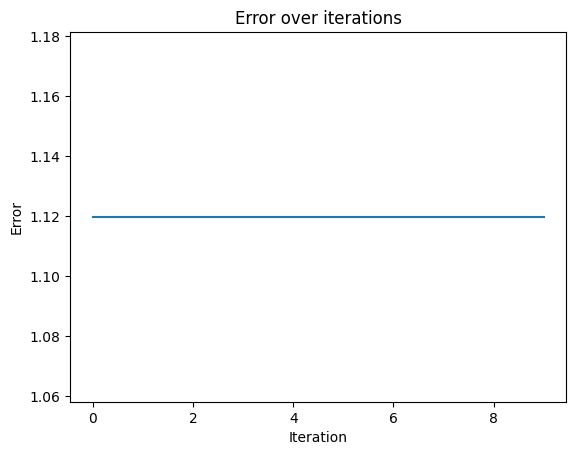

In [ ]:
def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:50]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    flower_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(flower_error)/len(flower_error))
#average of erro overt the time 
plt.plot(flower_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  0
Error:  1.1197781116536607
Weights after iteration is:  [ 0.00000000e+00  1.38252414e+00  0.00000000e+00  3.29747915e-03
  3.85285729e+00  0.00000000e+00  0.00000000e+00  1.16096508e+00
 -2.48287357e+00  1.37205046e+01 -4.91988547e+00 -1.25758397e+00
  0.00000000e+00 -0.00000000e+00 -8.88112989e-01 -0.00000000e+00
 -7.73344583e+00  2.03885364e-01  2.28523001e-01  0.00000000e+00
 -1.51369106e+00]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  1
Error:  1.1197781116536607
Weights after iteration is:  [ 1.17959437  0.          0.         -0.          0.10428761  1.12056117
 -0.          1.31393359 -0.26105414 -1.82998968  0.57746055  0.
 -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  2
Error:  1.1197781116536607
Weights after iteration is:  [-0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.59736769e+00 -5.00454157e-01  1.07830666e+01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.14456125e+00  0.00000000e+00  1.00000000e+00 -1.72277901e-01
 -2.15595882e-02  0.00000000e+00  7.84945948e+01 -8.89678767e-01
  4.49600680e-01]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  3
Error:  1.1197781116536607
Weights after iteration is:  [-2.22164901 -0.         -0.         -4.94799187  0.         -0.
  0.10301562 -0.          0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.          0.
 -0.03170363  1.         -3.74177542]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  4
Error:  1.1197781116536607
Weights after iteration is:  [-0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.07786648e+01
 -1.90641290e+01  4.84982221e-02  0.00000000e+00 -9.93555292e-02
  0.00000000e+00 -0.00000000e+00 -1.11257958e+00 -1.10165715e-02
 -0.00000000e+00]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  5
Error:  1.1197781116536607
Weights after iteration is:  [-0.          0.         -0.46481911  0.          6.04635198  0.
 -0.          0.          0.          0.         -0.          0.
  2.99535791  0.          0.         -2.19981697 -0.          0.97317626
  0.         -0.          0.29879144]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  6
Error:  1.1197781116536607
Weights after iteration is:  [ 0.         -0.         -0.         -0.         19.08165533 -0.
 -3.0440127   0.          8.41416205  1.04174703 -1.08812097  0.03470565
 -0.          0.24526686  1.          0.71805574 -0.          0.01922012
 -0.          2.01693543 -0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  7
Error:  1.1197781116536607
Weights after iteration is:  [-7.13768818e-01  7.29916421e+00  1.00000000e+00 -1.55732646e+00
  0.00000000e+00  5.21889080e-04  0.00000000e+00 -3.98796465e+00
  0.00000000e+00 -0.00000000e+00  2.74916369e-01  0.00000000e+00
  8.77777854e-01  5.43892143e-01  0.00000000e+00  8.40384806e-01
  6.74597940e-01  1.00000000e+00  0.00000000e+00 -2.14104313e+00
  0.00000000e+00]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  8
Error:  1.1197781116536607
Weights after iteration is:  [-4.06398954e-01  3.60826089e+02  1.75442257e+00  0.00000000e+00
  3.53379821e+00  0.00000000e+00  2.05356801e+00 -0.00000000e+00
  4.44668635e+00 -1.34486950e+00  3.29716773e+00 -9.20077642e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.85597807e-02
 -0.00000000e+00 -1.01407041e+00 -0.00000000e+00 -0.00000000e+00
 -9.67206621e-03]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/3320991161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  9
Error:  1.1197781116536607
Weights after iteration is:  [-0.         -1.60584403  1.         -2.13605139  1.11722581  2.26682332
  0.         -0.79458363  0.          0.12092201 -0.         -0.
 -2.13470094  2.65237768 -0.          1.          0.          0.
  0.93236691  0.44104619 -0.69991339]
Mean absolute error for all iterations:  1.1197781116536607


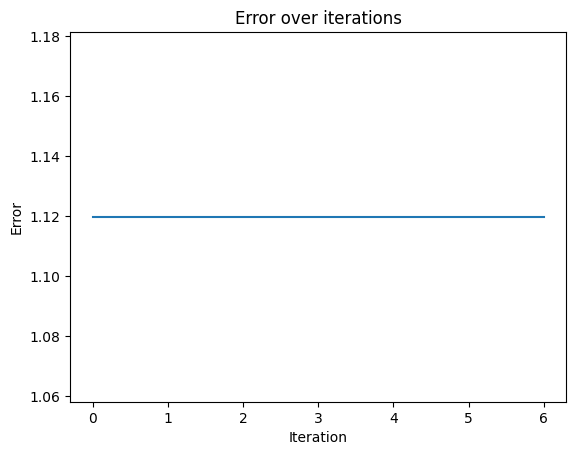

In [68]:
def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:50]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
flower_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    #print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(fuzzy_error)/len(fuzzy_error))
#average of erro overt the time 
plt.plot(fuzzy_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()

/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  0
Error:  1.1197781116536607
Weights after iteration is:  [ 1.         -0.         -0.36214543 -6.04048315  0.70432908  6.45559257
  0.          0.          0.         -0.         -0.         -0.
  0.         -0.42365807 -1.0076966   1.44479631  3.42379703  0.
  1.4281151   0.55777244  0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  1
Error:  1.1197781116536607
Weights after iteration is:  [ 0.          0.          0.          1.          0.          1.
  0.79143554  1.20147394 -0.59334834  0.          0.          7.21046674
 -0.07366666  0.         -0.         -1.13408061 -2.26438432  8.92259231
  0.         -2.86542531  1.67200036]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  2
Error:  1.1197781116536607
Weights after iteration is:  [-0.          0.0288419   0.9751781  -0.          0.         -0.03381795
 -0.          0.          0.          0.          0.         -0.
  0.          0.76872665  0.         -0.          0.          0.
 -1.64066267 -0.          1.26244503]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  3
Error:  1.1197781116536607
Weights after iteration is:  [-0.          0.          2.61121058  4.10883638  0.         -0.
  2.02454032 -0.29425002  0.          0.76370021 -0.          0.
  0.          0.          0.         -0.         -0.         -0.
  3.95452628 19.00810597  0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  4
Error:  1.1197781116536607
Weights after iteration is:  [-4.5816367  -3.55013731 -3.90041251  1.         -0.04237622 -1.31646445
  0.          0.68736961 -0.47610251 -7.37619883 -0.          0.
  0.          0.31413903 -3.36946833  1.12544169  0.          2.13229024
  0.          6.58255914 10.98212265]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  5
Error:  1.1197781116536607
Weights after iteration is:  [ 0.          0.09272877 -0.17309868 -1.93393422 -2.28427914 -0.
  1.5955898  41.06443441  1.51834128 -1.15752787  0.38355083  0.64028158
  0.          0.         -1.89811438  0.83439534 -0.         -0.
  1.          1.          0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  6
Error:  1.1197781116536607
Weights after iteration is:  [ 0.         -0.         -0.02816536 -3.52679028  0.         -0.
  0.         -0.          4.64697222 -0.          2.00161603 -0.18837257
  3.73239476  0.          0.         -0.          0.         -1.94559731
 -3.70879398  0.          0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  7
Error:  1.1197781116536607
Weights after iteration is:  [-0.00000000e+00 -2.14499845e+00  6.20665496e+01 -4.85031127e+01
 -0.00000000e+00 -1.01149858e+00  6.85503363e-04 -5.00703171e+00
  3.16722166e+00  5.64074917e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.12967765e+01
  0.00000000e+00 -2.22949780e-01  0.00000000e+00 -3.47110472e+00
  0.00000000e+00]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  8
Error:  1.1197781116536607
Weights after iteration is:  [-0.          0.          1.42798359 -0.         -2.02104085  1.24831871
 -0.          0.         -0.40506245 -0.          0.          0.
 -0.6211079   0.20355619 -0.          0.          0.         -0.88380471
  0.          1.44302691  0.        ]


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7244/2878506597.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]


Iteration :  9
Error:  1.1197781116536607
Weights after iteration is:  [ 3.69672429e+01 -1.04649252e+01  0.00000000e+00 -0.00000000e+00
  6.61440683e-02 -0.00000000e+00 -1.29454452e+00 -2.51135819e-01
 -1.75298177e+00  2.32309155e-01  1.00000000e+00  2.30750344e+00
 -0.00000000e+00  2.27518921e+02 -1.78953927e-01 -1.07536713e+00
 -1.70094417e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
Mean absolute error for all iterations:  1.1197781116536603


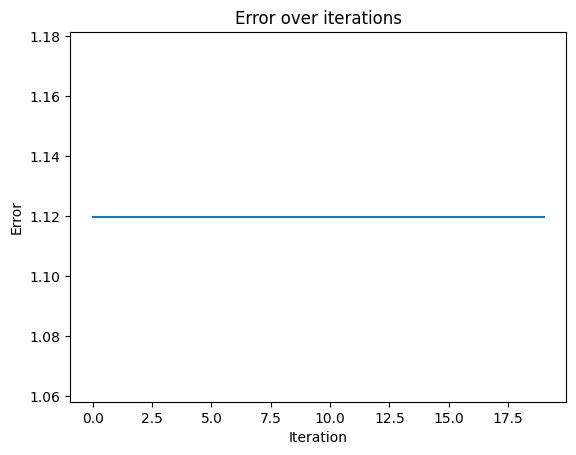

In [69]:
def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:50]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    genetic_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(genetic_error)/len(genetic_error))
#average of erro overt the time 
plt.plot(genetic_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()

In [76]:
flower_error

Ellipsis

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(genetic_error))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.2  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width, flower_error, bar_width, label='Flower')
rects2 = ax.bar(x, genetic_error, bar_width, label='Genetic')
rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.set_title('Error over iterations for Flower, Genetic and Fuzzy algorithms')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()

plt.show()

TypeError: object of type 'ellipsis' has no len()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(flower_error))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.2  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width, flower_error, bar_width, label='Flower')
rects2 = ax.bar(x, genetic_error, bar_width, label='Genetic')
rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.set_title('Error over iterations for Flower, Genetic and Fuzzy algorithms')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()


plt.show()




ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (0,).

In [ ]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, f1_score,multilabel_confusion_matrix


# Convert predicted ratings to discrete classes
predicted_classes = [round(rating) for rating in predicated_ratings]

actual_ratings = np.array(actual_ratings)
predicted_classes = np.array(predicted_classes)

print(mean_absolute_error(actual_ratings, predicted_classes))
print(f1_score(actual_ratings, predicted_classes, average='weighted'))


0.5776630689816987
0.5341889082241121
